In [1]:
import requests
from bs4 import BeautifulSoup
from urllib import request 
import zipfile
import pandas as pd
from pandas import Timestamp
import matplotlib.pyplot as plt
import plotnine as pn
import numpy as np
import datetime as dt

In [2]:
URL = 'https://covid19.ssi.dk/overvagningsdata/download-fil-med-overvaagningdata'
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')

In [3]:
latest_link = soup.find('blockquote').find('a')['href']

In [4]:
latest_link

'https://files.ssi.dk/covid19/overvagning/data/data-epidemiologiske-rapport-25022021-1us0'

In [5]:
filehandle, _ = request.urlretrieve(latest_link)

In [6]:
zip_file_object = zipfile.ZipFile(filehandle, 'r')

In [7]:
zip_file_object.namelist()

['0_read_me.txt',
 'Cases_by_age.csv',
 'Cases_by_sex.csv',
 'Deaths_over_time.csv',
 'Municipality_cases_time_series.csv',
 'Municipality_tested_persons_time_series.csv',
 'Municipality_test_pos.csv',
 'Newly_admitted_over_time.csv',
 'Region_summary.csv',
 'Rt_cases_2021_02_23.csv',
 'Test_pos_over_time.csv',
 'Test_regioner.csv']

In [8]:
zip_Test_pos_over_time = zip_file_object.open('Test_pos_over_time.csv')
zip_Newly_admitted_over_time = zip_file_object.open('Newly_admitted_over_time.csv')
zip_Deaths_over_time = zip_file_object.open('Deaths_over_time.csv')

In [9]:
df_Test_pos_over_time = pd.read_csv(zip_Test_pos_over_time,sep=";",skipfooter=4,parse_dates=True, thousands='.')
df_Newly_admitted_over_time = pd.read_csv(zip_Newly_admitted_over_time,skipfooter=1,sep=";",parse_dates=True, thousands='.')
df_Deaths_over_time = pd.read_csv(zip_Deaths_over_time,sep=";",skipfooter=3,parse_dates=True, thousands='.')

# Tests over time

In [10]:
df_Test_pos_over_time.head(5)

,Date,NewPositive,NotPrevPos,PosPct,PrevPos,Tested,Tested_kumulativ
0,2020-01-27,0,0,"0,0",0,0,0
1,2020-01-28,0,0,"0,0",0,0,0
2,2020-01-29,0,0,"0,0",0,0,0
3,2020-01-30,0,0,"0,0",0,0,0
4,2020-01-31,0,0,"0,0",0,0,0


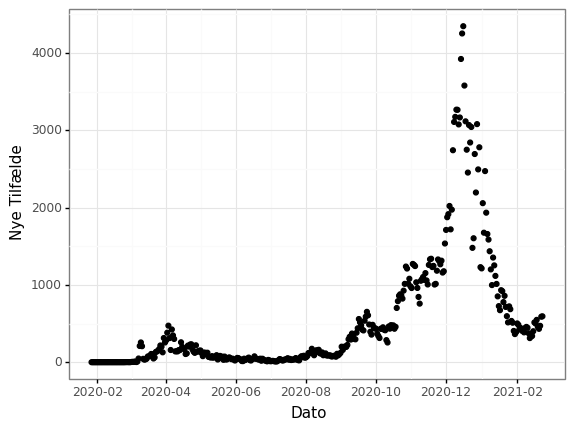

<ggplot: (153636808015)>

In [11]:
(
    pn.ggplot(df_Test_pos_over_time, pn.aes('Date', 'NewPositive'))
 + pn.geom_point() 
 + pn.geom_smooth()
 + pn.scale_x_date(date_breaks='2 months',date_labels="%Y-%m")
 + pn.theme_bw() 
 + pn.labs(x="Dato",y="Nye Tilfælde")
 )

## 14 day incidence

In [12]:
df_Test_pos_over_time["14DayIncidence"] = df_Test_pos_over_time.NewPositive.rolling(14).sum()/5793636*100000

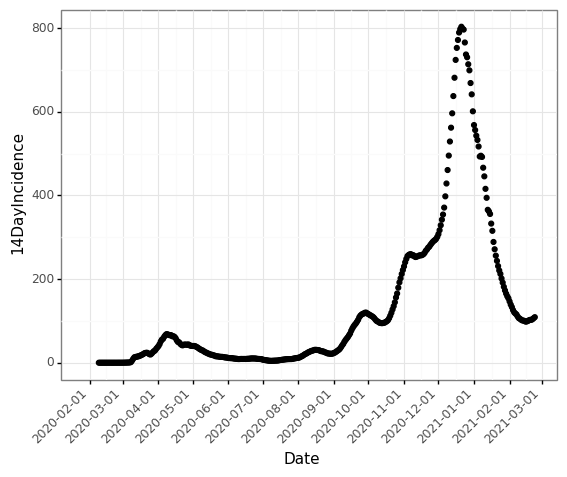

<ggplot: (153636808045)>

In [13]:
(
    pn.ggplot(df_Test_pos_over_time,pn.aes(x="Date",y="14DayIncidence")) 
    + pn.geom_point() 
    + pn.scale_x_date(date_breaks="1 months") 
    + pn.theme_bw()
    + pn.theme(axis_text_x=pn.element_text(angle=45,hjust=1))
)

## Regression exponential

In [14]:
df_regression = df_Test_pos_over_time[df_Test_pos_over_time["Date"]>"2020-12-22"]

x = pd.to_datetime(df_regression['Date'])
x = x.map(dt.datetime.toordinal)
y = np.log(df_regression.NewPositive)

fit_exp = np.polyfit(x,y,1, cov=True)

In [15]:
ordinals = np.arange(start = max(x),stop = max(x) + 90)
date_range = pd.date_range(dt.datetime.today(),periods=90)
pred = np.exp(np.polyval(fit_exp[0],ordinals))
lwr = np.exp(np.polyval(fit_exp[1][0],ordinals))
upr = np.exp(np.polyval(fit_exp[1][1],ordinals))

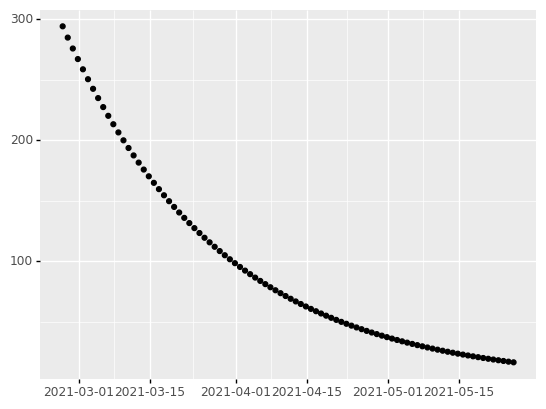

<ggplot: (153636902123)>

In [16]:
pn.ggplot(pn.aes(x=date_range,y=pred)) + pn.geom_point()

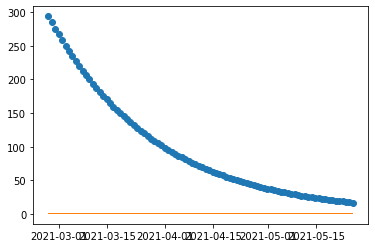

In [17]:
plt.clf()
plt.scatter(x = date_range, y = pred)
plt.fill_between(x = date_range, y1 = lwr, y2 = upr)
plt.show()

In [18]:
datelist = pd.Series(pd.date_range(dt.datetime.today(),periods=90))
dates = np.polyval(fit_exp,datelist.apply(lambda x: x.toordinal()))

ValueError: could not broadcast input array from shape (2,2) into shape (2)

# Rt calculation

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/

Please set verbose=2 to see the detailed citation list.


Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


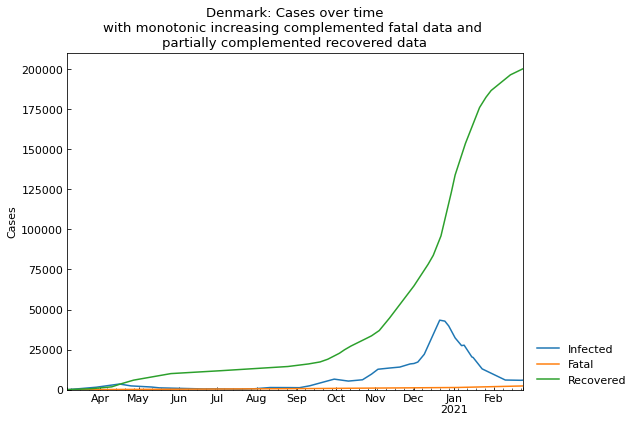

,Date,Infected,Fatal,Recovered
0,2020-03-06,22,0,1
1,2020-03-07,22,0,1
2,2020-03-08,34,0,1
3,2020-03-09,89,0,1
4,2020-03-10,222,0,40
...,...,...,...,...
351,2021-02-20,5722,2333,199026
352,2021-02-21,5790,2338,199449
353,2021-02-22,5866,2343,199818
354,2021-02-23,5950,2343,200263


In [20]:
import covsirphy as cs
# Download and update datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()
# Check records
snl = cs.Scenario(jhu_data, population_data, country="Denmark")

In [23]:
complement_snl_df = snl.show_complement()
complement_snl_df.tail()

,Country,Province,Monotonic_confirmed,Monotonic_fatal,Monotonic_recovered,Full_recovered,Partial_recovered
0,Denmark,-,False,True,False,False,True


In [22]:
# Parameter estimation of SIR-F model
snl.estimate(cs.SIRF)

UnExecutedError: Please execute .trend() or .add() in advance.

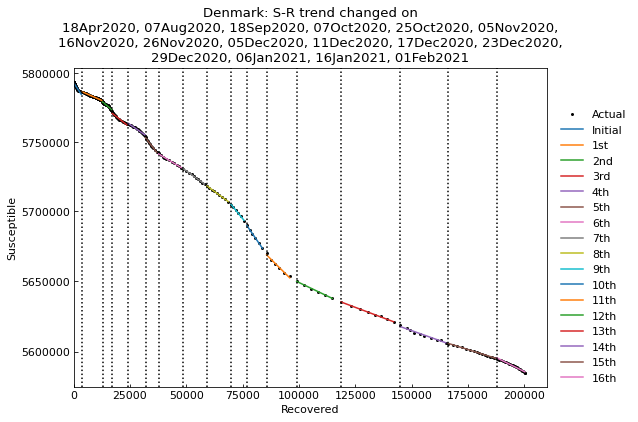

,Type,Start,End,Population
0th,Past,06Mar2020,17Apr2020,5793636
1st,Past,18Apr2020,06Aug2020,5793636
2nd,Past,07Aug2020,17Sep2020,5793636
3rd,Past,18Sep2020,06Oct2020,5793636
4th,Past,07Oct2020,24Oct2020,5793636
5th,Past,25Oct2020,04Nov2020,5793636
6th,Past,05Nov2020,15Nov2020,5793636
7th,Past,16Nov2020,25Nov2020,5793636
8th,Past,26Nov2020,04Dec2020,5793636
9th,Past,05Dec2020,10Dec2020,5793636


In [24]:

snl.trend(set_phases=True)
snl.summary()

In [25]:
# Estimate the parameter values of SIR-F model
# Default value of timeout is 180 sec
snl.estimate(cs.SIRF, timeout=60)


<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...
	15th phase (06Jan2021 - 15Jan2021): finished  937 trials in 0 min 40 sec
Completed optimization. Total: 2 min 28 sec


In [26]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/beta [day],1/alpha2 [day],alpha1 [-],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,06Mar2020,17Apr2020,5793636,SIR-F,3.76,0.085758,0.000243,0.126678,0.030538,1440,7,4114,0.086,32,2.071002,817,1 min 0 sec
1st,Past,18Apr2020,06Aug2020,5793636,SIR-F,0.70,0.036083,0.000560,0.056905,0.077720,1440,17,1785,0.036,12,0.242392,798,1 min 0 sec
2nd,Past,07Aug2020,17Sep2020,5793636,SIR-F,1.36,0.000664,0.000255,0.085901,0.062733,1440,11,3927,0.001,15,0.148205,899,1 min 0 sec
3rd,Past,18Sep2020,06Oct2020,5793636,SIR-F,1.64,0.001008,0.000216,0.086731,0.052607,1440,11,4624,0.001,19,0.063430,829,1 min 0 sec
4th,Past,07Oct2020,24Oct2020,5793636,SIR-F,1.01,0.001008,0.000216,0.084857,0.083997,1440,11,4638,0.001,11,0.050941,818,1 min 0 sec
5th,Past,25Oct2020,04Nov2020,5793636,SIR-F,2.19,0.000357,0.000403,0.098207,0.044511,1440,10,2484,0.000,22,0.022498,901,1 min 0 sec
6th,Past,05Nov2020,15Nov2020,5793636,SIR-F,1.07,0.000435,0.000185,0.076459,0.071186,1440,13,5407,0.000,14,0.016198,609,0 min 40 sec
7th,Past,16Nov2020,25Nov2020,5793636,SIR-F,1.12,0.001713,0.000095,0.090429,0.080450,1440,11,10568,0.002,12,0.010503,141,0 min 10 sec
8th,Past,26Nov2020,04Dec2020,5793636,SIR-F,1.20,0.000410,0.000362,0.090240,0.074497,1440,11,2759,0.000,13,0.005133,487,0 min 30 sec
9th,Past,05Dec2020,10Dec2020,5793636,SIR-F,1.99,0.001418,0.000054,0.110628,0.055408,1440,9,18407,0.001,18,0.010065,138,0 min 10 sec


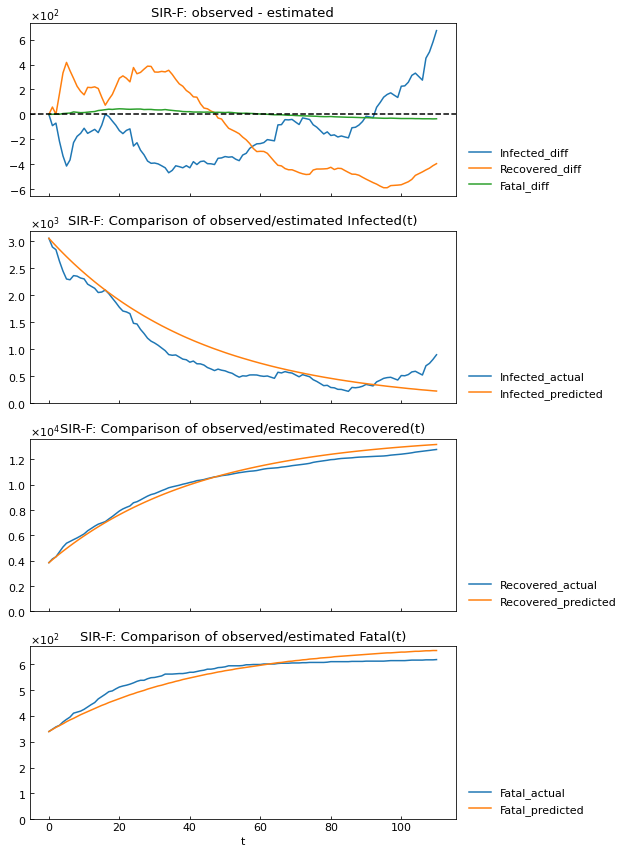

In [27]:
snl.estimate_accuracy(phase="1st")

In [28]:
snl.get("Rt", phase="4th")

1.01

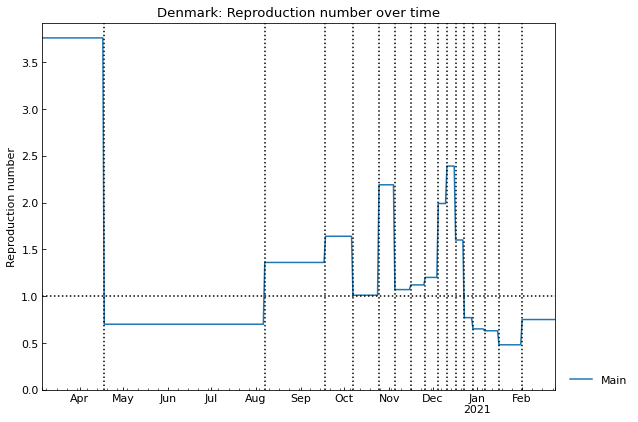

In [29]:
_ = snl.history(target="Rt")

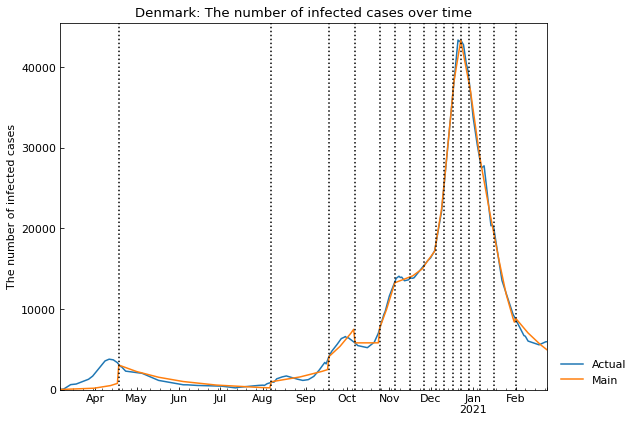

In [30]:
_ = snl.history("Infected")